In [34]:
import copy
import torch.optim.lr_scheduler
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

In [35]:
from create_translate_data import create_dateset, truncate_pad
from util import *
from attention import *

In [36]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs):
        super(PositionWiseFFN, self).__init__()
        self.layer1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.layer2(self.relu(self.layer1(X)))

In [37]:
class AddNorm(nn.Module):
    def __init__(self, shape, dropout, use_bias=False):
        super(AddNorm, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(shape)
        self.use_bias = use_bias
        if self.use_bias:
            self.bias = nn.Parameter(torch.zeros(shape))

    def forward(self, X, Y):
        if self.use_bias:
            return self.layer_norm(X + Y + self.bias)
        else:
            return self.layer_norm(X + self.dropout(Y))

In [38]:
class AddNorm_no_ln(nn.Module):
    def __init__(self, shape, dropout, use_bias=False):
        super(AddNorm_no_ln, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(shape)
        self.use_bias = use_bias
        if self.use_bias:
            self.bias = nn.Parameter(torch.zeros(shape))

    def forward(self, X, Y):
        if self.use_bias:
            return X + Y + self.bias
        else:
            return X + self.dropout(Y)

In [39]:
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super(EncoderBlock, self).__init__()
        self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout, use_bias)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout, use_bias)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

# X = torch.ones((2, 100, 24))
# valid_lens = torch.tensor([3, 2])
# encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
# encoder_blk.eval()

In [40]:
class EncoderBlock_no_ln(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super(EncoderBlock_no_ln, self).__init__()
        self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm_no_ln(norm_shape, dropout, use_bias)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm_no_ln(norm_shape, dropout, use_bias)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

# X = torch.ones((2, 100, 24))
# valid_lens = torch.tensor([3, 2])
# encoder_blk = EncoderBlock_no_ln(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
# encoder_blk.eval()

In [41]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False):
        super(TransformerEncoder, self).__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("encoder_blk_%d" % i, EncoderBlock(key_size, query_size, value_size, num_hiddens,
                                                                    norm_shape, ffn_num_input, ffn_num_hiddens,
                                                                    num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X


# encoder = TransformerEncoder(
#     200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
# encoder.eval()

In [42]:
class TransformerEncoder_no_ln(nn.Module):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False):
        super(TransformerEncoder_no_ln, self).__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("encoder_blk_%d" % i, EncoderBlock_no_ln(key_size, query_size, value_size, num_hiddens,
                                                                    norm_shape, ffn_num_input, ffn_num_hiddens,
                                                                    num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X


# encoder = TransformerEncoder(
#     200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
# encoder.eval()

In [43]:
class DecoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, dropout, i, use_bias=False):
        super(DecoderBlock, self).__init__()
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout, use_bias)
        self.attention2 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout, use_bias)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout, use_bias)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]

        batch_size, num_steps, _ = X.shape
        dec_valid_lens = torch.arange(
            1, num_steps + 1, device=X.device).repeat(batch_size, 1)

        X2 = self.attention1(X, X, X, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [44]:
class DecoderBlock_no_ln(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, dropout, i, use_bias=False):
        super(DecoderBlock_no_ln, self).__init__()
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm_no_ln(norm_shape, dropout, use_bias)
        self.attention2 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm_no_ln(norm_shape, dropout, use_bias)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm_no_ln(norm_shape, dropout, use_bias)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]

        batch_size, num_steps, _ = X.shape
        dec_valid_lens = torch.arange(
            1, num_steps + 1, device=X.device).repeat(batch_size, 1)

        X2 = self.attention1(X, X, X, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [45]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False):
        super(TransformerDecoder, self).__init__()
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("decoder_blk_%d" % i, DecoderBlock(key_size, query_size, value_size, num_hiddens,
                                                                    norm_shape, ffn_num_input, ffn_num_hiddens,
                                                                    num_heads, dropout, i, use_bias))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        self.seqX = None
        return [enc_outputs, enc_valid_lens]

    def forward(self, X, state):
        if not self.training:
            self.seqX = X if self.seqX is None else torch.cat((self.seqX, X), dim=1)
            X = self.seqX

        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights

        if not self.training:
            return self.dense(X)[:, -1:, :], state

        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights


In [46]:
class TransformerDecoder_no_ln(nn.Module):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False):
        super(TransformerDecoder_no_ln, self).__init__()
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("decoder_blk_%d" % i, DecoderBlock_no_ln(key_size, query_size, value_size, num_hiddens,
                                                                    norm_shape, ffn_num_input, ffn_num_hiddens,
                                                                    num_heads, dropout, i, use_bias))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        self.seqX = None
        return [enc_outputs, enc_valid_lens]

    def forward(self, X, state):
        if not self.training:
            self.seqX = X if self.seqX is None else torch.cat((self.seqX, X), dim=1)
            X = self.seqX

        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights

        if not self.training:
            return self.dense(X)[:, -1:, :], state

        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights


In [47]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, enc_valid_lens):
        enc_outputs = self.encoder(enc_X, enc_valid_lens)
        dec_state = self.decoder.init_state(enc_outputs, enc_valid_lens)
        return self.decoder(dec_X, dec_state)

In [48]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 60
num_epochs = 1000
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
corpus_size = 1000
key_size, query_size, value_size = 32, 32, 32
norm_shape = [num_hiddens]
en_file = 'en-de/train.en-de.low.filt.en'
de_file = 'en-de/train.en-de.low.filt.de'
data_iter, input_vocab, target_vocab = create_dateset(en_file, de_file, corpus_size, 2, 10, device, batch_size)
loss = MaskedSoftmaxCELoss()


In [49]:
acc_test_input = []
test_files_input = open(en_file, 'r', encoding='UTF-8')
line = test_files_input.readline().strip().split()
acc_test_input.append(' '.join(line[:20]))
for i in range(99):
    line = test_files_input.readline().strip().split()
    if len(line) > 20:
        acc_test_input.append(' '.join(line[:20]))
    else:
        acc_test_input.append(' '.join(line))
test_files_input.close()

In [50]:
acc_test_input

["with vibrant video clips captured by submarines , david gallo takes us to some of earth 's darkest , most",
 "david gallo : this is bill lange . i 'm dave gallo .",
 "and we 're going to tell you some stories from the sea here in video .",
 "we 've got some of the most incredible video of titanic that 's ever been seen , and we 're",
 "the truth of the matter is that the titanic -- even though it 's breaking all sorts of box office",
 'and the problem , i think , is that we take the ocean for granted .',
 'when you think about it , the oceans are 75 percent of the planet .',
 'most of the planet is ocean water .',
 'the average depth is about two miles .',
 'part of the problem , i think , is we stand at the beach , or we see images like',
 'and in the oceans , there are the longest mountain ranges on the planet .',
 'most of the animals are in the oceans .',
 'most of the earthquakes and volcanoes are in the sea , at the bottom of the sea .',
 'the biodiversity and the biodensity in

In [51]:
acc_test_target = []
test_files_target = open(de_file, 'r', encoding='UTF-8')
line = test_files_target.readline().strip().split()
acc_test_target.append(line[:20])
for i in range(99):
    line = test_files_target.readline().strip().split()
    if len(line) > 20:
        acc_test_target.append(line[:20])
    else:
        acc_test_target.append(line)
test_files_target.close()

In [52]:
acc_test_target

[['mit',
  'hilfe',
  'von',
  'lebendigen',
  'videos',
  ',',
  'die',
  'von',
  'unterseebooten',
  'gemacht',
  'wurden',
  ',',
  'führt',
  'uns',
  'david',
  'gallo',
  'zu',
  'den',
  'dunkelsten',
  ','],
 ['david',
  'gallo',
  ':',
  'das',
  'ist',
  'bill',
  'lange',
  '.',
  'ich',
  'bin',
  'dave',
  'gallo',
  '.'],
 ['wir',
  'werden',
  'ihnen',
  'einige',
  'geschichten',
  'über',
  'das',
  'meer',
  'in',
  'videoform',
  'erzählen',
  '.'],
 ['wir',
  'haben',
  'ein',
  'paar',
  'der',
  'unglaublichsten',
  'aufnahmen',
  'der',
  'titanic',
  ',',
  'die',
  'man',
  'je',
  'gesehen',
  'hat',
  ',',
  ',',
  'und',
  'wir',
  'werden'],
 ['die',
  'wahrheit',
  'ist',
  ',',
  'dass',
  'die',
  'titanic',
  '–',
  'obwohl',
  'sie',
  'alle',
  'kinokassenrekorde',
  'bricht',
  '–',
  'nicht',
  'gerade',
  'die',
  'aufregendste',
  'geschichte',
  'vom'],
 ['ich',
  'denke',
  ',',
  'das',
  'problem',
  'ist',
  ',',
  'dass',
  'wir',
  'das',


[['mit',
  'hilfe',
  'von',
  'lebendigen',
  'videos',
  ',',
  'die',
  'von',
  'unterseebooten',
  'gemacht',
  'wurden',
  ',',
  'führt',
  'uns',
  'david',
  'gallo',
  'zu',
  'den',
  'dunkelsten',
  ','],
 ['david',
  'gallo',
  ':',
  'das',
  'ist',
  'bill',
  'lange',
  '.',
  'ich',
  'bin',
  'dave',
  'gallo',
  '.'],
 ['wir',
  'werden',
  'ihnen',
  'einige',
  'geschichten',
  'über',
  'das',
  'meer',
  'in',
  'videoform',
  'erzählen',
  '.'],
 ['wir',
  'haben',
  'ein',
  'paar',
  'der',
  'unglaublichsten',
  'aufnahmen',
  'der',
  'titanic',
  ',',
  'die',
  'man',
  'je',
  'gesehen',
  'hat',
  ',',
  ',',
  'und',
  'wir',
  'werden'],
 ['die',
  'wahrheit',
  'ist',
  ',',
  'dass',
  'die',
  'titanic',
  '–',
  'obwohl',
  'sie',
  'alle',
  'kinokassenrekorde',
  'bricht',
  '–',
  'nicht',
  'gerade',
  'die',
  'aufregendste',
  'geschichte',
  'vom'],
 ['ich',
  'denke',
  ',',
  'das',
  'problem',
  'ist',
  ',',
  'dass',
  'wir',
  'das',


In [53]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps, device, save_attention_weights=False):
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq


In [54]:
def predict_seq2seq_beam(net, src_sentence, src_vocab, tgt_vocab, num_steps, device, k=3, save_attention_weights=False):
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    max_prob = -float('inf')
    max_output_seq, max_attention_weight_seq = [], []
    # beam first step, pick top 3
    Y, dec_state = net.decoder(dec_X, dec_state)
    top_dec_X = torch.topk(Y, k=k, dim=2)
    for i in top_dec_X[0].to(torch.long).permute(2, 0, 1):
        curr_prob = i
        dec_X = i
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
        for _ in range(1, num_steps):
            Y, dec_state = net.decoder(dec_X, dec_state)
            dec_X = Y.argmax(dim=2)
            pred = dec_X.squeeze(dim=0).type(torch.int32).item()
            if save_attention_weights:
                attention_weight_seq.append(net.decoder.attention_weights)
            if pred == tgt_vocab['<eos>']:
                break
            output_seq.append(pred)
        if curr_prob.float() > max_prob:
            max_prob = curr_prob
            max_output_seq = output_seq
            max_attention_weight_seq = attention_weight_seq
        output_seq, attention_weight_seq = [], []

    return ' '.join(tgt_vocab.to_tokens(max_output_seq)), max_attention_weight_seq

In [55]:
def train_transformer(model, num_epochs, data_iter, optimizer, scheduler):
    best_loss = float('inf')
    # learning_curve = [np.nan] * (num_epochs//10+1)
    # bleu_scores = [np.nan] * (num_epochs//10+1)
    losses_list = []
    for epoch in range(num_epochs):
        metric = Accumulator(2)
        model.train()
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([target_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            Y_hat, _ = model(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            grad_clipping(model, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        # if epoch == 0:
        #     learning_curve[0] = metric[0] / metric[1]
        #     model.eval()
        #     bleu_scores[0] = 0
        #     for sent in range(len(acc_test_input)):
        #         target_len = len(acc_test_target[sent])
        #         pred, dec_att_wei = predict_seq2seq(model, acc_test_input[sent], input_vocab, target_vocab, target_len, device, True)
        #         bleu_scores[0] += bleu(pred, ' '.join(acc_test_target[sent]), len(pred.split()))
        losses_list.append(metric[0] / metric[1])
        if (epoch + 1) % 10 == 0:
            print('Epoch: {}/{}.............'.format(epoch+1, num_epochs), end=' ')
            print("Loss: {:.4f}".format((metric[0] / metric[1])))
            # learning_curve[(epoch+1)//10] = metric[0] / metric[1]
            # model.eval()
            # bleu_scores[(epoch+1)//10] = 0
            # for sent in range(len(acc_test_input)):
            #     target_len = len(acc_test_target[sent])
            #     pred, dec_att_wei = predict_seq2seq(model, acc_test_input[sent], input_vocab, target_vocab, target_len, device, True)
            #     bleu_scores[(epoch+1)//10] += bleu(pred, ' '.join(acc_test_target[sent]), len(pred.split()))
            # print('Epoch: {}/{}.............'.format(epoch+1, num_epochs), end=' ')
            # print("Bleu: {:.4f}".format(bleu_scores[(epoch+1)//10]))

        if (metric[0] / metric[1]) < best_loss:
            best_loss = (metric[0] / metric[1])
            best_weights = copy.deepcopy(model.state_dict())
            torch.save(best_weights, 'transformer_weights_'+str(corpus_size)+'_sentences_' +
                       str(num_epochs)+'_epochs.pth')
        scheduler.step()

    return losses_list

In [56]:
def train_transformer_no_ln(model, num_epochs, data_iter, optimizer, scheduler):
    best_loss = float('inf')
    # learning_curve = [np.nan] * (num_epochs//10+1)
    # bleu_scores = [np.nan] * (num_epochs//10+1)
    losses_list = []
    for epoch in range(num_epochs):
        metric = Accumulator(2)
        model.train()
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([target_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            Y_hat, _ = model(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            grad_clipping(model, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        # if epoch == 0:
        #     learning_curve[0] = metric[0] / metric[1]
        #     model.eval()
        #     bleu_scores[0] = 0
        #     for sent in range(len(acc_test_input)):
        #         target_len = len(acc_test_target[sent])
        #         pred, dec_att_wei = predict_seq2seq(model, acc_test_input[sent], input_vocab, target_vocab, target_len, device, True)
        #         bleu_scores[0] += bleu(pred, ' '.join(acc_test_target[sent]), len(pred.split()))
        losses_list.append(metric[0] / metric[1])
        if (epoch + 1) % 10 == 0:
            print('Epoch: {}/{}.............'.format(epoch+1, num_epochs), end=' ')
            print("Loss: {:.4f}".format((metric[0] / metric[1])))
            # learning_curve[(epoch+1)//10] = metric[0] / metric[1]
            # model.eval()
            # bleu_scores[(epoch+1)//10] = 0
            # for sent in range(len(acc_test_input)):
            #     target_len = len(acc_test_target[sent])
            #     pred, dec_att_wei = predict_seq2seq(model, acc_test_input[sent], input_vocab, target_vocab, target_len, device, True)
            #     bleu_scores[(epoch+1)//10] += bleu(pred, ' '.join(acc_test_target[sent]), len(pred.split()))
            # print('Epoch: {}/{}.............'.format(epoch+1, num_epochs), end=' ')
            # print("Bleu: {:.4f}".format(bleu_scores[(epoch+1)//10]))

        if (metric[0] / metric[1]) < best_loss:
            best_loss = (metric[0] / metric[1])
            best_weights = copy.deepcopy(model.state_dict())
            torch.save(best_weights, 'transformer_no_ln_weights_'+str(corpus_size)+'_sentences_' +
                       str(num_epochs)+'_epochs.pth')
        scheduler.step()

    return losses_list

In [57]:
training_results = {}

In [58]:
lr = 0.002
encoder = TransformerEncoder(len(input_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads,num_layers, dropout).to(device)
decoder = TransformerDecoder(len(target_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads,num_layers, dropout).to(device)
model = EncoderDecoder(encoder, decoder).to(device)
optimizer_002 = torch.optim.Adam(model.parameters(), lr=lr)
scheduler_002 = torch.optim.lr_scheduler.MultiStepLR(optimizer_002, milestones=[num_epochs//5, num_epochs*2//5,
                                                                        num_epochs*3//5, num_epochs*4//5], gamma=0.6)
training_results['transformer_ln_'+str(lr)] = train_transformer(model, num_epochs, data_iter, optimizer_002, scheduler_002)

Epoch: 10/1000............. Loss: 0.4583
Epoch: 20/1000............. Loss: 0.3853
Epoch: 30/1000............. Loss: 0.3348
Epoch: 40/1000............. Loss: 0.2909
Epoch: 50/1000............. Loss: 0.2626
Epoch: 60/1000............. Loss: 0.2363
Epoch: 70/1000............. Loss: 0.2164
Epoch: 80/1000............. Loss: 0.1990
Epoch: 90/1000............. Loss: 0.1844
Epoch: 100/1000............. Loss: 0.1715
Epoch: 110/1000............. Loss: 0.1622
Epoch: 120/1000............. Loss: 0.1543
Epoch: 130/1000............. Loss: 0.1456
Epoch: 140/1000............. Loss: 0.1376
Epoch: 150/1000............. Loss: 0.1320
Epoch: 160/1000............. Loss: 0.1273
Epoch: 170/1000............. Loss: 0.1214
Epoch: 180/1000............. Loss: 0.1178
Epoch: 190/1000............. Loss: 0.1134
Epoch: 200/1000............. Loss: 0.1092
Epoch: 210/1000............. Loss: 0.1037
Epoch: 220/1000............. Loss: 0.0981
Epoch: 230/1000............. Loss: 0.0965
Epoch: 240/1000............. Loss: 0.0958
E

In [59]:
# model.load_state_dict(torch.load('transformer_weights_'+str(corpus_size)+'_sentences_' + str(num_epochs)+'_epochs.pth'))
# model.eval()

In [60]:
# training_results['transformer_ln_0.002']

In [61]:
lr = 0.002
encoder = TransformerEncoder_no_ln(len(input_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads,num_layers, dropout).to(device)
decoder = TransformerDecoder_no_ln(len(target_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads,num_layers, dropout).to(device)
model = EncoderDecoder(encoder, decoder).to(device)
optimizer_002 = torch.optim.Adam(model.parameters(), lr=lr)
scheduler_002 = torch.optim.lr_scheduler.MultiStepLR(optimizer_002, milestones=[num_epochs//5, num_epochs*2//5,
                                                                                num_epochs*3//5, num_epochs*4//5], gamma=0.6)
training_results['transformer_no_ln_'+str(lr)] = train_transformer_no_ln(model, num_epochs, data_iter, optimizer_002, scheduler_002)

Epoch: 10/1000............. Loss: 0.4344
Epoch: 20/1000............. Loss: 0.3707
Epoch: 30/1000............. Loss: 0.3354
Epoch: 40/1000............. Loss: 0.3147
Epoch: 50/1000............. Loss: 0.2981
Epoch: 60/1000............. Loss: 0.2824
Epoch: 70/1000............. Loss: 0.2730
Epoch: 80/1000............. Loss: 0.2634
Epoch: 90/1000............. Loss: 0.2533
Epoch: 100/1000............. Loss: 0.2452
Epoch: 110/1000............. Loss: 0.2391
Epoch: 120/1000............. Loss: 0.2350
Epoch: 130/1000............. Loss: 0.2266
Epoch: 140/1000............. Loss: 0.2212
Epoch: 150/1000............. Loss: 0.2168
Epoch: 160/1000............. Loss: 0.2157
Epoch: 170/1000............. Loss: 0.2110
Epoch: 180/1000............. Loss: 0.2062
Epoch: 190/1000............. Loss: 0.2024
Epoch: 200/1000............. Loss: 0.2002
Epoch: 210/1000............. Loss: 0.1885
Epoch: 220/1000............. Loss: 0.1826
Epoch: 230/1000............. Loss: 0.1827
Epoch: 240/1000............. Loss: 0.1791
E

In [62]:
training_results['transformer_no_ln_0.002']

[1.2256487014051272,
 0.7885961409629059,
 0.6134781451437947,
 0.5427197198539223,
 0.5092853634031397,
 0.4883519867917393,
 0.4717644461867825,
 0.4576674682901012,
 0.4453371008060821,
 0.43444500400863323,
 0.4248865127966636,
 0.4153218774305693,
 0.4082892092759401,
 0.4014789127340984,
 0.3926940785732362,
 0.38870934305168864,
 0.38274487721393385,
 0.3775420091137577,
 0.3741938853661975,
 0.37069271251329333,
 0.3645766634589344,
 0.36230862717677864,
 0.35677311521734556,
 0.35514028287543675,
 0.3511479082835247,
 0.3473958346234444,
 0.34563149722528064,
 0.3430633770691318,
 0.3380248933129723,
 0.33537798687812514,
 0.3344162703316349,
 0.33130209210608885,
 0.3288934869308649,
 0.3264562364512532,
 0.32459986655864825,
 0.3236918492741525,
 0.32018732858293786,
 0.3181292030529602,
 0.3149853885564359,
 0.3147146313267565,
 0.3134850441741782,
 0.3095524670381774,
 0.30811069611892267,
 0.3073016085853488,
 0.3065010099828281,
 0.30366207051040306,
 0.30174077900185237

[1.2022781710724477,
 0.7758429653673287,
 0.6097079615491159,
 0.5393947826281483,
 0.5056638796267513,
 0.4850715809759391,
 0.47022274890577936,
 0.45694927311528183,
 0.4450208897369907,
 0.43397108008256297,
 0.4238926160413653,
 0.41437243306593974,
 0.4071604378554514,
 0.3986550288582372,
 0.39326796514542955,
 0.3867531524251818,
 0.3816477489935069,
 0.3756390097679988,
 0.36981479352081437,
 0.3680257416255276,
 0.3617552404700009,
 0.35915709217162645,
 0.356179951160006,
 0.35232234479911834,
 0.34935282189355693,
 0.34501377993470594,
 0.34183085168851807,
 0.34066373655343,
 0.3355908761743107,
 0.3324556594619638,
 0.3315125688945131,
 0.3291474840046865,
 0.32618363758797525,
 0.32390114077300153,
 0.320947889393718,
 0.31862974197107097,
 0.317115628878074,
 0.31384708805281775,
 0.3133591091726074,
 0.3118484374509758,
 0.30941679572938136,
 0.30763945884922295,
 0.3051728115755064,
 0.30139140804583464,
 0.30295981465825267,
 0.3018464253937006,
 0.29875156496927263

In [63]:
lr = 0.0005
encoder = TransformerEncoder(len(input_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads,num_layers, dropout).to(device)
decoder = TransformerDecoder(len(target_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads,num_layers, dropout).to(device)
model = EncoderDecoder(encoder, decoder).to(device)
optimizer_002 = torch.optim.Adam(model.parameters(), lr=lr)
scheduler_002 = torch.optim.lr_scheduler.MultiStepLR(optimizer_002, milestones=[num_epochs//5, num_epochs*2//5,
                                                                                num_epochs*3//5, num_epochs*4//5], gamma=0.6)
training_results['transformer_ln_'+str(lr)] = train_transformer(model, num_epochs, data_iter, optimizer_002, scheduler_002)

Epoch: 10/1000............. Loss: 0.5322
Epoch: 20/1000............. Loss: 0.4955
Epoch: 30/1000............. Loss: 0.4680
Epoch: 40/1000............. Loss: 0.4453
Epoch: 50/1000............. Loss: 0.4245
Epoch: 60/1000............. Loss: 0.4071
Epoch: 70/1000............. Loss: 0.3897
Epoch: 80/1000............. Loss: 0.3746
Epoch: 90/1000............. Loss: 0.3609
Epoch: 100/1000............. Loss: 0.3470
Epoch: 110/1000............. Loss: 0.3347
Epoch: 120/1000............. Loss: 0.3224
Epoch: 130/1000............. Loss: 0.3108
Epoch: 140/1000............. Loss: 0.3002
Epoch: 150/1000............. Loss: 0.2903
Epoch: 160/1000............. Loss: 0.2803
Epoch: 170/1000............. Loss: 0.2725
Epoch: 180/1000............. Loss: 0.2631
Epoch: 190/1000............. Loss: 0.2549
Epoch: 200/1000............. Loss: 0.2484
Epoch: 210/1000............. Loss: 0.2430
Epoch: 220/1000............. Loss: 0.2378
Epoch: 230/1000............. Loss: 0.2335
Epoch: 240/1000............. Loss: 0.2303
E

In [64]:
lr = 0.0005
encoder = TransformerEncoder_no_ln(len(input_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input,
                                   ffn_num_hiddens, num_heads,num_layers, dropout).to(device)
decoder = TransformerDecoder_no_ln(len(target_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input,
                                   ffn_num_hiddens, num_heads,num_layers, dropout).to(device)
model = EncoderDecoder(encoder, decoder).to(device)
optimizer_002 = torch.optim.Adam(model.parameters(), lr=lr)
scheduler_002 = torch.optim.lr_scheduler.MultiStepLR(optimizer_002, milestones=[num_epochs//5, num_epochs*2//5,
                                                                                num_epochs*3//5, num_epochs*4//5], gamma=0.6)
training_results['transformer_no_ln_'+str(lr)] = train_transformer_no_ln(model, num_epochs, data_iter, optimizer_002, scheduler_002)

Epoch: 10/1000............. Loss: 0.5803
Epoch: 20/1000............. Loss: 0.4855
Epoch: 30/1000............. Loss: 0.4443
Epoch: 40/1000............. Loss: 0.4167
Epoch: 50/1000............. Loss: 0.3941
Epoch: 60/1000............. Loss: 0.3760
Epoch: 70/1000............. Loss: 0.3632
Epoch: 80/1000............. Loss: 0.3502
Epoch: 90/1000............. Loss: 0.3392
Epoch: 100/1000............. Loss: 0.3293
Epoch: 110/1000............. Loss: 0.3224
Epoch: 120/1000............. Loss: 0.3133
Epoch: 130/1000............. Loss: 0.3052
Epoch: 140/1000............. Loss: 0.2997
Epoch: 150/1000............. Loss: 0.2932
Epoch: 160/1000............. Loss: 0.2849
Epoch: 170/1000............. Loss: 0.2827
Epoch: 180/1000............. Loss: 0.2766
Epoch: 190/1000............. Loss: 0.2721
Epoch: 200/1000............. Loss: 0.2667
Epoch: 210/1000............. Loss: 0.2598
Epoch: 220/1000............. Loss: 0.2580
Epoch: 230/1000............. Loss: 0.2561
Epoch: 240/1000............. Loss: 0.2521
E

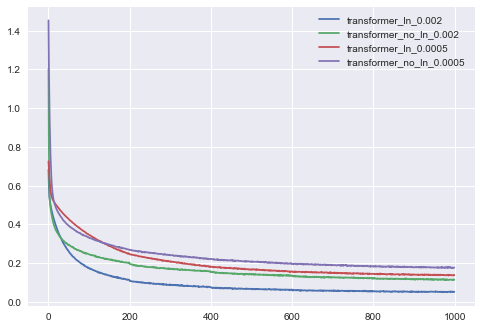

In [70]:
for key in training_results:
    curr_result = training_results[key]

    plt.plot(curr_result, label = key)
plt.legend()
plt.show()

In [66]:
translation, dec_attention_weight_seq = predict_seq2seq(model, "when you think about it", input_vocab, target_vocab
                                                        , 5, device, True)
print(translation)

wenn sie daran denken ,
aber es ist etwa 100


array([1.20227817, 0.77584297, 0.60970796, 0.53939478, 0.50566388,
       0.48507158, 0.47022275, 0.45694927, 0.44502089, 0.43397108,
       0.42389262, 0.41437243, 0.40716044, 0.39865503, 0.39326797,
       0.38675315, 0.38164775, 0.37563901, 0.36981479, 0.36802574,
       0.36175524, 0.35915709, 0.35617995, 0.35232234, 0.34935282,
       0.34501378, 0.34183085, 0.34066374, 0.33559088, 0.33245566,
       0.33151257, 0.32914748, 0.32618364, 0.32390114, 0.32094789,
       0.31862974, 0.31711563, 0.31384709, 0.31335911, 0.31184844,
       0.3094168 , 0.30763946, 0.30517281, 0.30139141, 0.30295981,
       0.30184643, 0.29875156, 0.29815325, 0.2934093 , 0.29297216,
       0.29310499, 0.29488445, 0.29130714, 0.28921683, 0.28767202,
       0.28725176, 0.28500607, 0.28450988, 0.28269317, 0.28430062,
       0.28107733, 0.27881721, 0.280666  , 0.27598106, 0.27447587,
       0.27456023, 0.27194905, 0.27291346, 0.27153496, 0.27155369,
       0.26665802, 0.26806811, 0.26737225, 0.26676079, 0.26563

In [79]:
loss_layer_02 = np.array(training_results['transformer_ln_0.002']).flatten()
loss_no_layer_02 = np.array(training_results['transformer_no_ln_0.002']).flatten()
loss_layer_005 = np.array(training_results['transformer_ln_0.0005']).flatten()
loss_no_layer_005 = np.array(training_results['transformer_no_ln_0.0005']).flatten()

min_curve_layer = []
max_curve_layer = []
min_curve_no_layer = []
max_curve_no_layer = []
for i in range(len(loss_layer_02)):
    min_curve_layer.append(np.min([loss_layer_02[i], loss_layer_005[i]]))
    max_curve_layer.append(np.max([loss_layer_02[i], loss_layer_005[i]]))
    min_curve_no_layer.append(np.min([loss_no_layer_02[i], loss_no_layer_005[i]]))
    max_curve_no_layer.append(np.max([loss_no_layer_02[i], loss_no_layer_005[i]]))

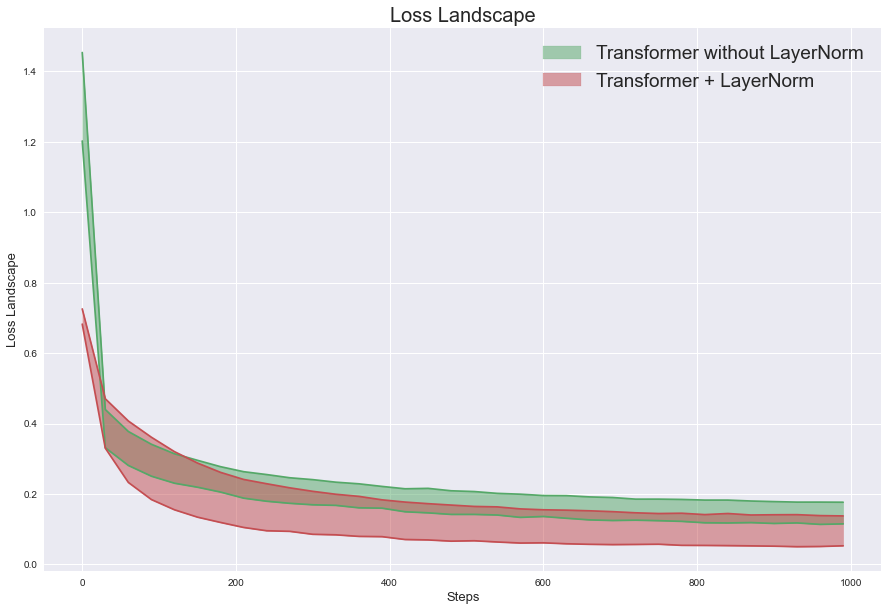

In [81]:
step = 30
steps = np.arange(0, len(min_curve_no_layer), step)
plt.figure(figsize=(15, 10))
plt.fill_between(steps, min_curve_no_layer[::step], max_curve_no_layer[::step],
                 alpha=0.5, color='C1', label='Transformer without LayerNorm')
plt.plot(steps, min_curve_no_layer[::step], color='C1')
plt.plot(steps, max_curve_no_layer[::step], color='C1')

plt.fill_between(steps, min_curve_layer[::step], max_curve_layer[::step],
                 alpha=0.5, color='C2', label='Transformer + LayerNorm')
plt.plot(steps, min_curve_layer[::step], color='C2')
plt.plot(steps, max_curve_layer[::step], color='C2')

plt.legend(fontsize=19)
plt.title('Loss Landscape', fontsize=20)
plt.ylabel('Loss Landscape', fontsize=13)
plt.xlabel('Steps', fontsize=13)
plt.savefig('transformer_loss_landscape.png', dpi=500, quality=100)
plt.show()